<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporando-Pacotes" data-toc-modified-id="Imporando-Pacotes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporando Pacotes</a></span></li><li><span><a href="#Função-de-Entrada" data-toc-modified-id="Função-de-Entrada-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Função de Entrada</a></span></li><li><span><a href="#Dicionários" data-toc-modified-id="Dicionários-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dicionários</a></span></li><li><span><a href="#Cenários" data-toc-modified-id="Cenários-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cenários</a></span></li><li><span><a href="#Otimização" data-toc-modified-id="Otimização-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Otimização</a></span></li></ul></div>

# Imporando Pacotes

In [252]:
# Importando as bibliotecas
import numpy as np # pacote para funções matemáticas
import pandas as pd # pacote para a manipulação dos dados em tabela
import warnings
import itertools
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt # pacote para fazer gráficos
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
import scikitplot as skplt
import sqlite3 as sql

import pandas_ta as ta
import talib

import mplfinance as mpf

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

pd.set_option("display.max_columns", 40)
pd.set_option('display.max_rows', 500)

In [253]:
from futures_backtester import Backtester

# Função de Entrada

In [254]:
def entrada(df, length_rsi, rsi_low, rsi_high, allowed_hours=None, position_type="both"):

    df = df.copy()  # Para evitar SettingWithCopyWarning
    
    # Calcular a variação percentual
    df['pct_change'] = df['close'].pct_change().fillna(0)
    
    # Calcula o RSI
    df['rsi'] = df.ta.rsi(length= length_rsi).fillna(0)
    
    # Determinar posições com base no position_type e RSI (lógica inversa)
    if position_type == "long":
        df['position'] = np.where((df['pct_change'] > 0) & (df['rsi'] > rsi_high), 1, 0)
    elif position_type == "short":
        df['position'] = np.where((df['pct_change'] < 0) & (df['rsi'] < rsi_low), -1, 0)
    else:  # "both" ou qualquer outro valor padrão
        long_condition = (df['pct_change'] > 0) & (df['rsi'] > rsi_high)
        short_condition = (df['pct_change'] < 0) & (df['rsi'] < rsi_low)
        
        df['position'] = np.where(long_condition, 1, np.where(short_condition, -1, 0))
    
    # Restrição de horários
    if allowed_hours is not None:
        # Zera posição fora dos horários permitidos
        current_hours = df.index.to_series().dt.hour
        df.loc[~current_hours.isin(allowed_hours), 'position'] = 0
    
    
    return df['position']

# Dicionários

In [255]:

path_b3 = 'C:/Users/User/OneDrive/Documentos/rnt/Finance/Trading Projects/00.database/candlestick data/futuros/'
path_tickmill = 'C:/Users/User/OneDrive/Documentos/rnt/Finance/Trading Projects/00.database/tickmill/forex/'

dict_custos = {'WIN@N':0.2*5, 'WDO@N':2.40/2,
                                     'AUDUSD': 3,
                                     'EURUSD': 3,
                                     'GBPUSD': 3,
                                     'NZDUSD': 3,
                                     'USDCHF': 3,
                                     'USDJPY': 3,
                                     'AUDCAD': 3,
                                     'AUDCHF': 3,
                                     'AUDJPY': 3,
                                     'AUDNZD': 3,
                                     'CADCHF': 3,
                                     'CADJPY': 3,
                                     'CHFJPY': 3,
                                     'EURAUD': 3,
                                     'EURCAD': 3,
                                     'EURCHF': 3,
                                     'EURGBP': 3,
                                     'EURHKD': 3,
                                     'EURJPY': 3,
                                     'EURMXN': 3,
                                     'EURNZD': 3,
                                     'EURTRY': 3,
                                     'GBPCAD': 3,
                                     'GBPCHF': 3,
                                     'GBPJPY': 3,
                                     'USDCNH': 3,
                                     'USDCZK': 3,
                                     'USDMXN': 3,
                                     'USDTRY': 3,
                                     'XAGUSD': 3,
                                     'XAUUSD': 3,
                                     'STOXX50': 3,
                                     'UK100': 3,
                                     'FRANCE40': 3,
                                     'VIX': 3,
                                     'ALUMINIUM': 3,
                                     'PLATINUM': 3,
                                     'LEAD': 3,
                                     'NICKEL': 3,
                                     'PALLADIUM': 3,
                                     'ZINC': 3,
                                     'COPPER': 3,
                                     'DXY': 3,
                                     'COCOA': 3,
                                     'SUGAR': 3,
                                     'WHEAT': 3,
                                     'US500': 3,
                                     'NAT.GAS': 3,
                                     'BRENT': 3,
                                     'EEM': 3,
                                     'EWZ': 3,
                                     'IWM': 3,
                                     'TLT': 3,
                                     'SPY': 3,
                                     'DIA': 3}

dict_valor_lot = {'WIN@N':0.2, 'WDO@N':10.0,
                                'USDCAD': 100000,
                                 'AUDUSD': 100000,
                                 'EURUSD': 100000,
                                 'GBPUSD': 100000,
                                 'NZDUSD': 100000,
                                 'USDCHF': 100000,
                                 'USDJPY': 100000,
                                 'AUDCAD': 100000,
                                 'AUDCHF': 100000,
                                 'AUDJPY': 100000,
                                 'AUDNZD': 100000,
                                 'CADCHF': 100000,
                                 'CADJPY': 100000,
                                 'CHFJPY': 100000,
                                 'EURAUD': 100000,
                                 'EURCAD': 100000,
                                 'EURCHF': 100000,
                                 'EURGBP': 100000,
                                 'EURHKD': 100000,
                                 'EURJPY': 100000,
                                 'EURMXN': 100000,
                                 'EURNZD': 100000,
                                 'EURTRY': 100000,
                                 'GBPCAD': 100000,
                                 'GBPCHF': 100000,
                                 'GBPJPY': 100000,
                                 'USDCNH': 100000,
                                 'USDCZK': 100000,
                                 'USDMXN': 100000,
                                 'USDTRY': 100000,
                                 'XAGUSD': 100000,
                                 'XAUUSD': 100000,
                                 'STOXX50': 100000,
                                 'UK100': 100000,
                                 'FRANCE40': 100000,
                                 'VIX': 100000,
                                 'ALUMINIUM': 100000,
                                 'PLATINUM': 100000,
                                 'LEAD': 100000,
                                 'NICKEL': 100000,
                                 'PALLADIUM': 100000,
                                 'ZINC': 100000,
                                 'COPPER': 100000,
                                 'DXY': 100000,
                                 'COCOA': 100000,
                                 'SUGAR': 100000,
                                 'WHEAT': 100000,
                                 'US500': 100000,
                                 'NAT.GAS': 100000,
                                 'BRENT': 100000,
                                 'EEM': 100000,
                                 'EWZ': 100000,
                                 'IWM': 100000,
                                 'TLT': 100000,
                                 'SPY': 100000,
                                 'DIA': 100000}

dict_path = {'WIN@N':path_b3, 'WDO@N':path_b3, 
                              'USDCAD': path_tickmill,
                             'AUDUSD': path_tickmill,
                             'EURUSD': path_tickmill,
                             'GBPUSD': path_tickmill,
                             'NZDUSD': path_tickmill,
                             'USDCHF': path_tickmill,
                             'USDJPY': path_tickmill,
                             'AUDCAD': path_tickmill,
                             'AUDCHF': path_tickmill,
                             'AUDJPY': path_tickmill,
                             'AUDNZD': path_tickmill,
                             'CADCHF': path_tickmill,
                             'CADJPY': path_tickmill,
                             'CHFJPY': path_tickmill,
                             'EURAUD': path_tickmill,
                             'EURCAD': path_tickmill,
                             'EURCHF': path_tickmill,
                             'EURGBP': path_tickmill,
                             'EURHKD': path_tickmill,
                             'EURJPY': path_tickmill,
                             'EURMXN': path_tickmill,
                             'EURNZD': path_tickmill,
                             'EURTRY': path_tickmill,
                             'GBPCAD': path_tickmill,
                             'GBPCHF': path_tickmill,
                             'GBPJPY': path_tickmill,
                             'USDCNH': path_tickmill,
                             'USDCZK': path_tickmill,
                             'USDMXN': path_tickmill,
                             'USDTRY': path_tickmill,
                             'XAGUSD': path_tickmill,
                             'XAUUSD': path_tickmill,
                             'STOXX50': path_tickmill,
                             'UK100': path_tickmill,
                             'FRANCE40': path_tickmill,
                             'VIX': path_tickmill,
                             'ALUMINIUM': path_tickmill,
                             'PLATINUM': path_tickmill,
                             'LEAD': path_tickmill,
                             'NICKEL': path_tickmill,
                             'PALLADIUM': path_tickmill,
                             'ZINC': path_tickmill,
                             'COPPER': path_tickmill,
                             'DXY': path_tickmill,
                             'COCOA': path_tickmill,
                             'SUGAR': path_tickmill,
                             'WHEAT': path_tickmill,
                             'US500': path_tickmill,
                             'NAT.GAS': path_tickmill,
                             'BRENT': path_tickmill,
                             'EEM': path_tickmill,
                             'EWZ': path_tickmill,
                             'IWM': path_tickmill,
                             'TLT': path_tickmill,
                             'SPY': path_tickmill,
                             'DIA': path_tickmill}

# Cenários

In [256]:
# win 5 min
{'sl': 300, 'tp': 620, 'LENGTH_RSI': 13, 'RSI_LOW': 30, 'RSI_HIGH': 70}
{'sl': 350, 'tp': 500, 'LENGTH_RSI': 9, 'RSI_LOW': 30, 'RSI_HIGH': 70}
{'sl': 400, 'tp': 570, 'LENGTH_RSI': 10, 'RSI_LOW': 22, 'RSI_HIGH': 76}
{'sl': 400, 'tp': 650, 'LENGTH_RSI': 14, 'RSI_LOW': 30, 'RSI_HIGH': 70}

# win 2 min
{'sl': 320, 'tp': 400, 'LENGTH_RSI': 16, 'RSI_LOW': 30, 'RSI_HIGH': 70}
{'sl': 320, 'tp': 1400, 'LENGTH_RSI': 16, 'RSI_LOW': 30, 'RSI_HIGH': 70}

# wdo 5 min
{'sl': 4, 'tp': 30, 'LENGTH_RSI': 11, 'RSI_LOW': 60, 'RSI_HIGH': 65}
{'sl': 12, 'tp': 28, 'LENGTH_RSI': 9, 'RSI_LOW': 37, 'RSI_HIGH': 80}
{'sl': 12, 'tp': 24, 'LENGTH_RSI': 10, 'RSI_LOW': 25, 'RSI_HIGH': 80}

# USDJPY 5 min
params = {'sl': 0.05000, 'tp': 0.15000, 'LENGTH_RSI': 9, 'RSI_LOW': 40, 'RSI_HIGH': 60}

In [588]:
params = {'sl': 800, 'tp': 200, 'LENGTH_RSI': 9, 'RSI_LOW': 28, 'RSI_HIGH': 72}
params = {'sl': 400, 'tp': 800, 'LENGTH_RSI': 18, 'RSI_LOW': 28, 'RSI_HIGH': 72}

In [589]:
# Configurar o backtester
sym = 'WIN@N'
#sym = 'WDO@N'
#sym = 'EURJPY'
#sym = 'USDJPY'

bt = Backtester(
    symbol = sym,
    timeframe = 't2',
    data_ini = '2023-01-01',
    data_fim = '2025-06-14',
    tp = params['tp'],
    sl = params['sl'],
    slippage = 0,
    tc = dict_custos[sym], # $ per lot
    lote = 1,
    valor_lote= dict_valor_lot[sym],
    initial_cash = 30000,
    path_base= dict_path[sym],
    daytrade = True
)


# Parâmetros da estratégia RSI
LENGTH_RSI = params['LENGTH_RSI']
RSI_LOW = params['RSI_LOW']
RSI_HIGH = params['RSI_HIGH']

# Executa o backtest com a estratégia RSI
results, metrics = bt.run(
    signal_function=entrada, 
    signal_args={
        "length_rsi": LENGTH_RSI,
        "rsi_low": RSI_LOW,
        "rsi_high": RSI_HIGH,
        'allowed_hours': [10,11,12,13,16,17],
        #'allowed_hours': [10,11,12],
        'position_type': "both"
    }
)


# Print de métricas
bt.print_metrics(metrics)

RELATÓRIO DE DESEMPENHO
Símbolo: WIN@N
Timeframe: t2
Período: 2023-01-01 a 2025-06-14

--- RESULTADOS ---
Saldo Inicial: $30000.00
Saldo Final: $67432.00
Retorno Total: $37432.00 (124.77%)
Retorno Anualizado: 64.11%
Volatilidade Anualizada: 24.96%

--- DRAWDOWN ---
Drawdown Máximo: 14.84%
Drawdown Máximo (Valor): $7477.00
Tempo Máximo em Drawdown: 28430.0 períodos
Tempo em Drawdown: 94.00% do total

--- TRADES ---
Total de Trades: 1427
Trades Vencedores: 677 (47.44%)
Trades Perdedores: 746 (52.56%)
Saídas por TP: 23.27%
Saídas por SL: 41.63%
Saídas por Tempo: 35.11%

--- RATIOS ---
Sharpe Ratio: 2.568
Sortino Ratio: 8.031
Calmar Ratio: 4.322
Profit Factor: 1.379

--- ANÁLISE DE GANHOS/PERDAS ---
Ganho Médio: $201.16
Perda Média: $132.38
Win/Loss Ratio: 1.52
Expectancy: $25.86


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 1400x1000 with 0 Axes>

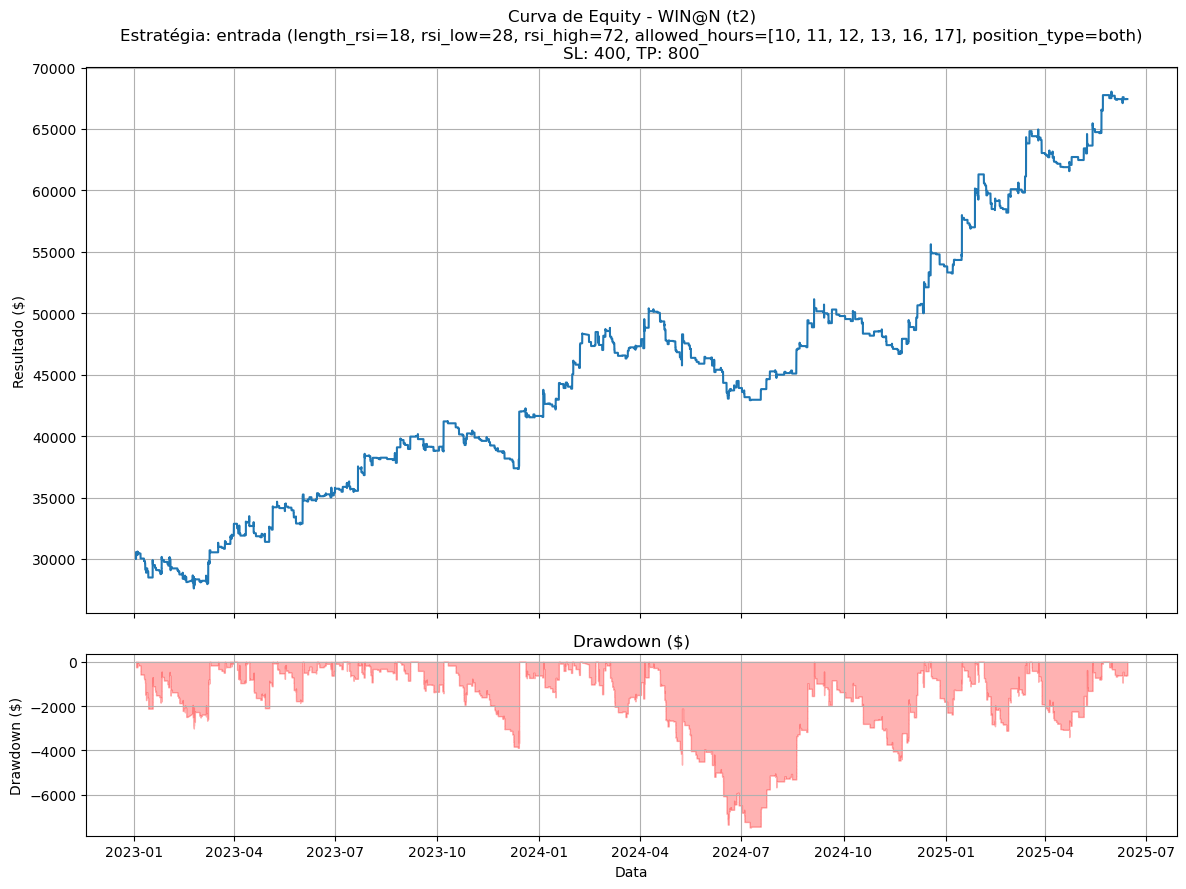

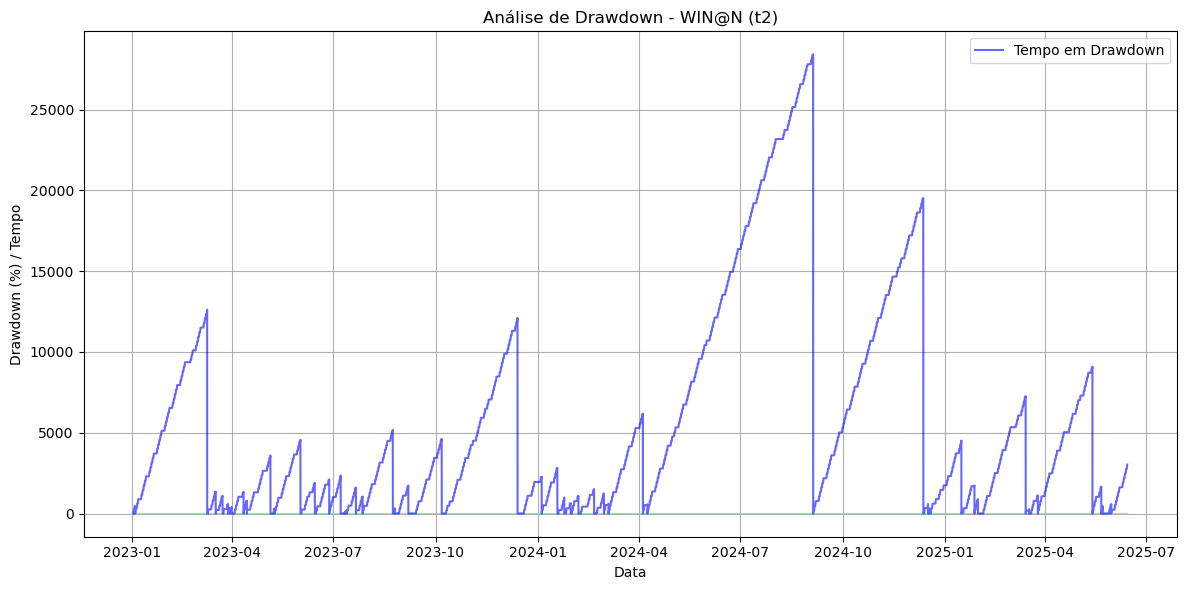

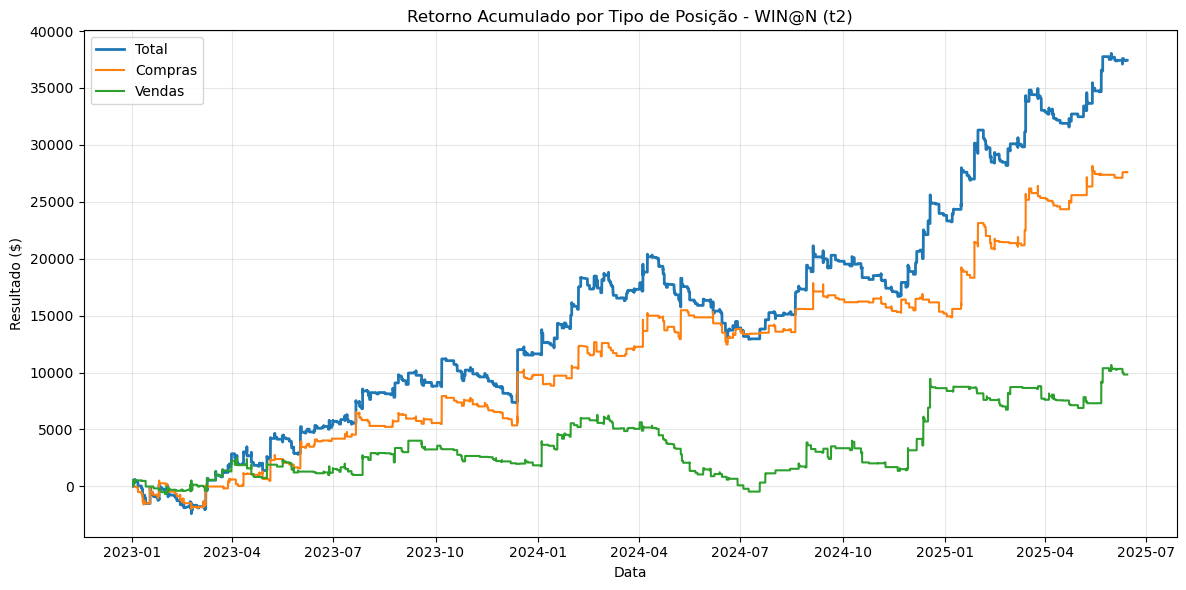

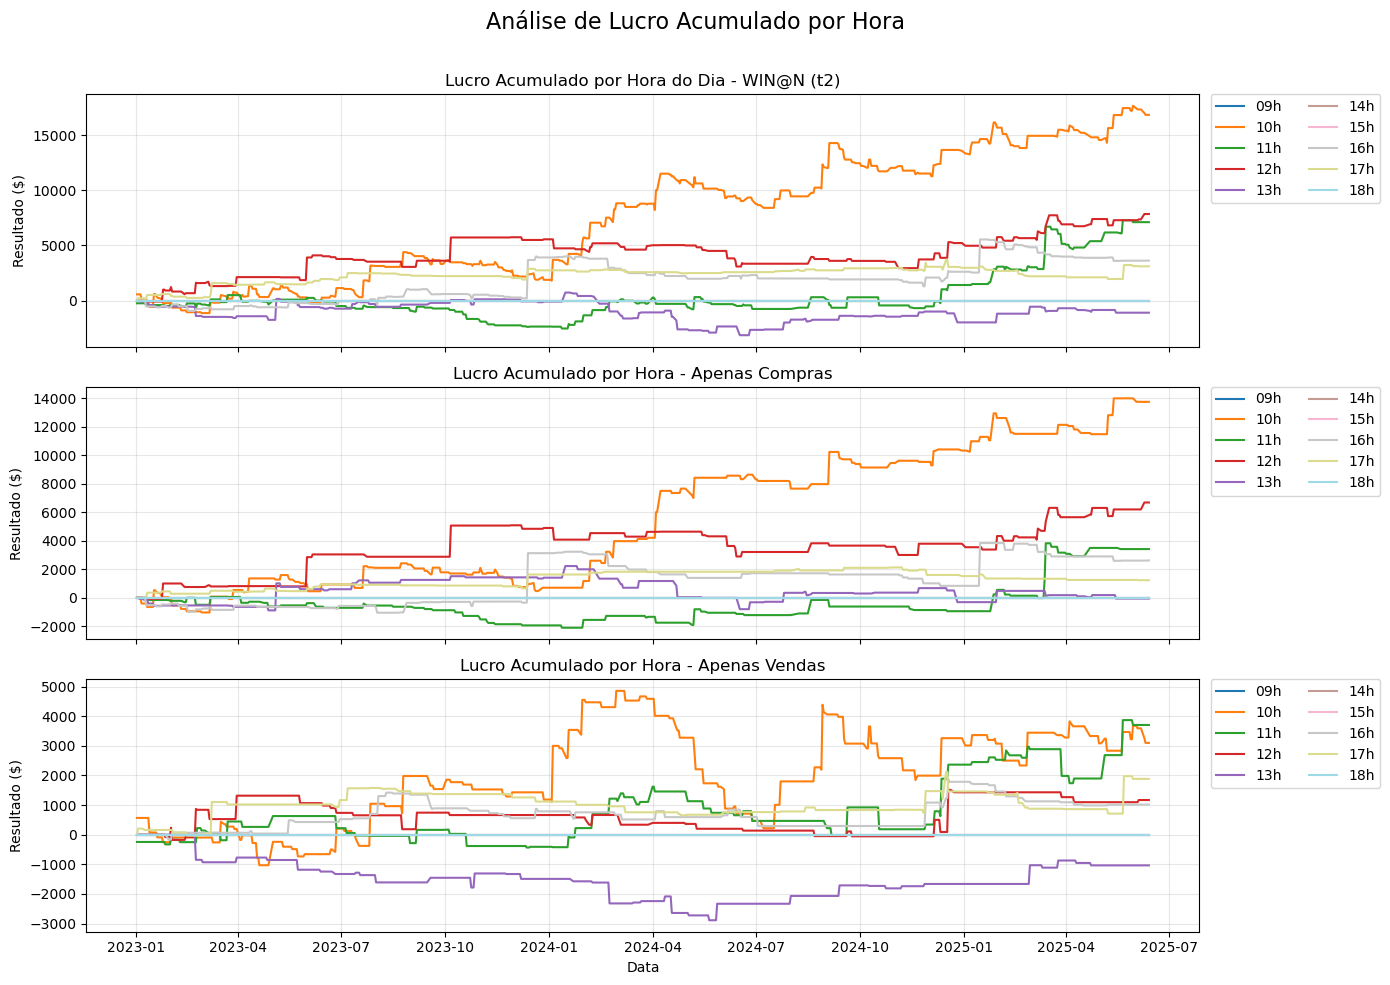

In [590]:
# Plotar a curva de equity com drawdown
plt.figure(figsize=(14, 10))

# 1. Curva de equity
plt = bt.plot_equity_curve(include_drawdown=True)

# 2. Análise detalhada de drawdown
plt = bt.plot_drawdown()

# 3. resultado por hora
bt.plot_by_position()
bt.plot_cumulative_by_hour()

# Otimização

In [9]:
metrics

{'initial_cash': 30000,
 'final_equity': 148663.0,
 'total_return': 118663.0,
 'total_return_pct': 395.54333333333335,
 'annual_return': 31.44768159985931,
 'annual_volatility': 19.604626512650096,
 'total_trades': 4524,
 'win_trades': 1342,
 'loss_trades': 3181,
 'win_rate': 0.29664014146772766,
 'tp_rate': 0.1275419982316534,
 'sl_rate': 0.6821396993810787,
 'time_exit_rate': 0.1903183023872679,
 'profit_factor': 1.3223793417281335,
 'max_drawdown': 0.5930061091215505,
 'max_drawdown_value': 8000.0,
 'max_time_underwater': 14470.0,
 'underwater_rate': 0.9632069316790093,
 'sharpe_ratio': 1.6040949099217656,
 'sortino_ratio': 6.519152395982275,
 'calmar_ratio': 0.5303095721297767,
 'avg_win': 362.70342771982115,
 'avg_loss': 115.71361207167557,
 'win_loss_ratio': 3.13449231448375,
 'expectancy': 26.204086292645513,
 'risk_free_rate': 0.0}

In [187]:
def objective_ind(trial):  
    
    '''
    função para maximizar os ganhos no mini-indice
    '''

    # Configurar o backtester
    sym = 'WDO@N'
    
    bt = Backtester(
        symbol = sym,
        timeframe = 't5',
        data_ini = '2019-01-01',
        data_fim = '2025-12-31',
        sl = trial.suggest_int('sl', 100, 2800),
        tp = trial.suggest_int('tp', 100, 2800),
        slippage = 0,
        tc = dict_custos[sym], # $ per lot
        lote = 1,
        valor_lote= dict_valor_lot[sym],
        initial_cash = 30000,
        path_base= dict_path[sym],
        daytrade = True
    )
    
    # Parâmetros da estratégia RSI
    LENGTH_RSI = trial.suggest_int('LENGTH_RSI', 4, 16)
    RSI_LOW = trial.suggest_int('RSI_LOW', 20, 50)
    RSI_HIGH = trial.suggest_int('RSI_HIGH', 50, 80)
    
    # Executa o backtest com a estratégia RSI
    _, metrics = bt.run(
        signal_function=entrada, 
        signal_args={
            "length_rsi": LENGTH_RSI,
            "rsi_low": RSI_LOW,
            "rsi_high": RSI_HIGH,
            'allowed_hours': [10,11,12,13,14,15,16]
        }
    )

    
    metrica = metrics['sharpe_ratio']
    #metrica = metrics['max_drawdown_value']
        
    return metrica

In [188]:
study = optuna.create_study(direction="maximize")

study.optimize(objective_ind, n_trials=220)

[I 2025-06-20 20:50:38,823] A new study created in memory with name: no-name-e24da7d1-f3dc-40c3-bce1-8eab3714c6f8
[I 2025-06-20 20:50:39,731] Trial 0 finished with value: 0.835876192066615 and parameters: {'sl': 2525, 'tp': 1232, 'LENGTH_RSI': 9, 'RSI_LOW': 32, 'RSI_HIGH': 70}. Best is trial 0 with value: 0.835876192066615.
[I 2025-06-20 20:50:40,659] Trial 1 finished with value: 0.8765401652956524 and parameters: {'sl': 1450, 'tp': 1879, 'LENGTH_RSI': 7, 'RSI_LOW': 28, 'RSI_HIGH': 61}. Best is trial 1 with value: 0.8765401652956524.
[I 2025-06-20 20:50:41,565] Trial 2 finished with value: -0.04603021028167927 and parameters: {'sl': 258, 'tp': 287, 'LENGTH_RSI': 10, 'RSI_LOW': 48, 'RSI_HIGH': 69}. Best is trial 1 with value: 0.8765401652956524.
[I 2025-06-20 20:50:42,498] Trial 3 finished with value: 1.4366376930542066 and parameters: {'sl': 2174, 'tp': 2169, 'LENGTH_RSI': 15, 'RSI_LOW': 45, 'RSI_HIGH': 50}. Best is trial 3 with value: 1.4366376930542066.
[I 2025-06-20 20:50:43,407] Tr

[I 2025-06-20 20:51:13,158] Trial 36 finished with value: 0.8764055078720964 and parameters: {'sl': 375, 'tp': 598, 'LENGTH_RSI': 14, 'RSI_LOW': 24, 'RSI_HIGH': 61}. Best is trial 24 with value: 1.6901388898829872.
[I 2025-06-20 20:51:14,069] Trial 37 finished with value: -0.25336308864002227 and parameters: {'sl': 320, 'tp': 143, 'LENGTH_RSI': 12, 'RSI_LOW': 48, 'RSI_HIGH': 53}. Best is trial 24 with value: 1.6901388898829872.
[I 2025-06-20 20:51:14,985] Trial 38 finished with value: 1.5308175338616887 and parameters: {'sl': 564, 'tp': 1239, 'LENGTH_RSI': 15, 'RSI_LOW': 33, 'RSI_HIGH': 66}. Best is trial 24 with value: 1.6901388898829872.
[I 2025-06-20 20:51:15,904] Trial 39 finished with value: -0.27682727042733357 and parameters: {'sl': 240, 'tp': 281, 'LENGTH_RSI': 10, 'RSI_LOW': 36, 'RSI_HIGH': 77}. Best is trial 24 with value: 1.6901388898829872.
[I 2025-06-20 20:51:16,822] Trial 40 finished with value: 1.100849497848349 and parameters: {'sl': 425, 'tp': 1879, 'LENGTH_RSI': 9, 'R

[I 2025-06-20 20:51:46,241] Trial 72 finished with value: 3.1491790737233516 and parameters: {'sl': 480, 'tp': 940, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 79}. Best is trial 72 with value: 3.1491790737233516.
[I 2025-06-20 20:51:47,155] Trial 73 finished with value: 3.2579155493217713 and parameters: {'sl': 359, 'tp': 1102, 'LENGTH_RSI': 16, 'RSI_LOW': 21, 'RSI_HIGH': 77}. Best is trial 73 with value: 3.2579155493217713.
[I 2025-06-20 20:51:48,060] Trial 74 finished with value: 3.054088514664191 and parameters: {'sl': 345, 'tp': 2743, 'LENGTH_RSI': 16, 'RSI_LOW': 21, 'RSI_HIGH': 77}. Best is trial 73 with value: 3.2579155493217713.
[I 2025-06-20 20:51:49,002] Trial 75 finished with value: 3.7151164358698043 and parameters: {'sl': 320, 'tp': 2426, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 79}. Best is trial 75 with value: 3.7151164358698043.
[I 2025-06-20 20:51:49,953] Trial 76 finished with value: 1.0325543031575797 and parameters: {'sl': 319, 'tp': 2797, 'LENGTH_RSI': 6, 'RSI

[I 2025-06-20 20:52:19,781] Trial 108 finished with value: 2.8962945292588422 and parameters: {'sl': 165, 'tp': 2448, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 78}. Best is trial 75 with value: 3.7151164358698043.
[I 2025-06-20 20:52:20,714] Trial 109 finished with value: 2.4927337573724504 and parameters: {'sl': 426, 'tp': 2581, 'LENGTH_RSI': 16, 'RSI_LOW': 22, 'RSI_HIGH': 77}. Best is trial 75 with value: 3.7151164358698043.
[I 2025-06-20 20:52:21,665] Trial 110 finished with value: 1.9597079099603938 and parameters: {'sl': 557, 'tp': 2376, 'LENGTH_RSI': 15, 'RSI_LOW': 23, 'RSI_HIGH': 76}. Best is trial 75 with value: 3.7151164358698043.
[I 2025-06-20 20:52:22,596] Trial 111 finished with value: 3.3797830504160538 and parameters: {'sl': 362, 'tp': 2665, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 78}. Best is trial 75 with value: 3.7151164358698043.
[I 2025-06-20 20:52:23,544] Trial 112 finished with value: 3.364474194940195 and parameters: {'sl': 362, 'tp': 2658, 'LENGTH_RSI': 1

KeyboardInterrupt: 

In [189]:
study.best_params

{'sl': 320, 'tp': 2426, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 79}